## CSAI Assignment-4
#### Akshit Sharma (2021101029)

In [21]:
import scipy.io
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import torch
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats

### Data Loading and pre-processing

In [22]:
data=scipy.io.loadmat('ROIs/CSI1/mat/CSI1_ROIs_TR34.mat')
with open('ROIs/stim_lists/CSI01_stim_lists.txt', 'r') as file:
    stimulus = file.read().splitlines()

In [23]:
data_LHearlyvis=data['LHEarlyVis']
data_RHearlyvis=data['RHEarlyVis']
data_earlyvis=np.concatenate((data_LHearlyvis,data_RHearlyvis), axis=1)
data_LHloc=data['LHLOC']
data_RHloc=data['RHLOC']
data_loc=np.concatenate((data_LHloc,data_RHloc), axis=1)
data_LHopa=data['LHOPA']
data_RHopa=data['RHOPA']
data_opa=np.concatenate((data_LHopa,data_RHopa), axis=1)
data_LHppa=data['LHPPA']
data_RHppa=data['RHPPA']
data_ppa=np.concatenate((data_LHppa,data_RHppa), axis=1)
data_LHrsc=data['LHRSC']
data_RHrsc=data['RHRSC']
data_rsc=np.concatenate((data_LHrsc,data_RHrsc), axis=1)

### Loading all 4916 images from the 3 folders present in Scene_Stimuli folder

In [24]:
first_occurrence = {}
unique_images=[]
for i, name in enumerate(stimulus):
    if name[:3]=='rep':
        stimulus[i]=name[4:]
        name=stimulus[i]
    if name not in first_occurrence:
        first_occurrence[name] = i
        unique_images.append(name)
data_earlyvis = np.array([row for i, row in enumerate(data_earlyvis) if i == first_occurrence[stimulus[i]]])
data_loc = np.array([row for i, row in enumerate(data_loc) if i == first_occurrence[stimulus[i]]])
data_opa = np.array([row for i, row in enumerate(data_opa) if i == first_occurrence[stimulus[i]]])
data_ppa = np.array([row for i, row in enumerate(data_ppa) if i == first_occurrence[stimulus[i]]])
data_rsc = np.array([row for i, row in enumerate(data_rsc) if i == first_occurrence[stimulus[i]]])
image_to_ind={}
for i,name in enumerate(unique_images):
    image_to_ind[name]=i

### Generating image representations using pre-trained ResNet

In [25]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
resnet18 = models.resnet18(weights='DEFAULT')
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
resnet18.eval()

image_data={}
folder_paths=['BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/COCO','BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/ImageNet','BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/Scene']
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))
        img_tensor = preprocess(img)
        img_tensor = img_tensor.unsqueeze(0)
        with torch.no_grad():
            features = resnet18(img_tensor)
        image_data[filename] = features.squeeze().numpy()

In [26]:
avg_corr_encoding=[]
avg_cossim_decoding=[]
mse_encoding=[]
eucdist_decoding=[]

## Encoding and Decoding for each ROI

### ROI: EarlyVis

In [27]:
# encoder
print("Encoder:")
X=list(image_data.values())
labels=list(image_data.keys())
y=[data_earlyvis[image_to_ind[i]] for i in labels]
X=np.array(X)
y=np.array(y)
y=stats.zscore(y,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(y_test.shape[0]):
    temp.append(np.corrcoef(y_test[i],y_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')
avg_corr_encoding.append(np.average(temp))
mse_encoding.append(test_mse)
print(f'R2_score:{r2_score(y_test,y_test_pred)}')
y_train_pred=best_ridge_model.predict(X_train)

# decoder
print("Decoder:")
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(y_train, X_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_dec_test_pred = best_ridge_model.predict(y_test)
test_mse = mean_squared_error(X_test, y_dec_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.dot(y_dec_test_pred[i],X_test[i])/(np.linalg.norm(X_test[i])*np.linalg.norm(y_dec_test_pred[i])))
print(f'Average Cosine Similarity: {np.average(temp)}')
avg_cossim_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.linalg.norm(y_dec_test_pred[i]-X_test[i]))
print(f'Average Euclidean Distance: {np.average(temp)}')
eucdist_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.corrcoef(X_test[i],y_dec_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')

Encoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.8875507350234483
Average Pearson Correlation: 0.33044699009038286
R2_score:0.014597538468767157
Decoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.7993132744922933
Average Cosine Similarity: 0.7288274048123661
Average Euclidean Distance: 20.005660847739982
Average Pearson Correlation: 0.20428625861496666


### ROI: LOC

In [28]:
# encoder
print("Encoder:")
X=list(image_data.values())
labels=list(image_data.keys())
y=[data_loc[image_to_ind[i]] for i in labels]
X=np.array(X)
y=np.array(y)
y=stats.zscore(y,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(y_test.shape[0]):
    temp.append(np.corrcoef(y_test[i],y_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')
avg_corr_encoding.append(np.average(temp))
mse_encoding.append(test_mse)
print(f'R2_score:{r2_score(y_test,y_test_pred)}')
y_train_pred=best_ridge_model.predict(X_train)

# decoder
print("Decoder:")
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(y_train, X_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_dec_test_pred = best_ridge_model.predict(y_test)
test_mse = mean_squared_error(X_test, y_dec_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.dot(y_dec_test_pred[i],X_test[i])/(np.linalg.norm(X_test[i])*np.linalg.norm(y_dec_test_pred[i])))
print(f'Average Cosine Similarity: {np.average(temp)}')
avg_cossim_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.linalg.norm(y_dec_test_pred[i]-X_test[i]))
print(f'Average Euclidean Distance: {np.average(temp)}')
eucdist_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.corrcoef(X_test[i],y_dec_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')

Encoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.8952314672415165
Average Pearson Correlation: 0.32238443725670357
R2_score:0.030097811511646987
Decoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.7885077811394112
Average Cosine Similarity: 0.7328931669166819
Average Euclidean Distance: 19.8707948202259
Average Pearson Correlation: 0.23007889414151486


### ROI: OPA

In [29]:
# encoder
print("Encoder:")
X=list(image_data.values())
labels=list(image_data.keys())
y=[data_opa[image_to_ind[i]] for i in labels]
X=np.array(X)
y=np.array(y)
y=stats.zscore(y,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(y_test.shape[0]):
    temp.append(np.corrcoef(y_test[i],y_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')
avg_corr_encoding.append(np.average(temp))
mse_encoding.append(test_mse)
print(f'R2_score:{r2_score(y_test,y_test_pred)}')
y_train_pred=best_ridge_model.predict(X_train)

# decoder
print("Decoder:")
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(y_train, X_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_dec_test_pred = best_ridge_model.predict(y_test)
test_mse = mean_squared_error(X_test, y_dec_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.dot(y_dec_test_pred[i],X_test[i])/(np.linalg.norm(X_test[i])*np.linalg.norm(y_dec_test_pred[i])))
print(f'Average Cosine Similarity: {np.average(temp)}')
avg_cossim_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.linalg.norm(y_dec_test_pred[i]-X_test[i]))
print(f'Average Euclidean Distance: {np.average(temp)}')
eucdist_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.corrcoef(X_test[i],y_dec_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')

Encoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.8618060529772467
Average Pearson Correlation: 0.36556049519888895
R2_score:0.03561457000714202
Decoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.7883215893615161
Average Cosine Similarity: 0.7332713589424891
Average Euclidean Distance: 19.86485362768712
Average Pearson Correlation: 0.23078923036022406


### ROI: PPA

In [30]:
# encoder
print("Encoder:")
X=list(image_data.values())
labels=list(image_data.keys())
y=[data_ppa[image_to_ind[i]] for i in labels]
X=np.array(X)
y=np.array(y)
y=stats.zscore(y,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(y_test.shape[0]):
    temp.append(np.corrcoef(y_test[i],y_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')
avg_corr_encoding.append(np.average(temp))
mse_encoding.append(test_mse)
print(f'R2_score:{r2_score(y_test,y_test_pred)}')
y_train_pred=best_ridge_model.predict(X_train)

# decoder
print("Decoder:")
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(y_train, X_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_dec_test_pred = best_ridge_model.predict(y_test)
test_mse = mean_squared_error(X_test, y_dec_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.dot(y_dec_test_pred[i],X_test[i])/(np.linalg.norm(X_test[i])*np.linalg.norm(y_dec_test_pred[i])))
print(f'Average Cosine Similarity: {np.average(temp)}')
avg_cossim_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.linalg.norm(y_dec_test_pred[i]-X_test[i]))
print(f'Average Euclidean Distance: {np.average(temp)}')
eucdist_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.corrcoef(X_test[i],y_dec_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')

Encoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.9302014942437175
Average Pearson Correlation: 0.24934237529626463
R2_score:0.018517890649996316
Decoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.7956247409819694
Average Cosine Similarity: 0.7301576187908684
Average Euclidean Distance: 19.963923499947175
Average Pearson Correlation: 0.21334973757226403


### ROI: RSC

In [31]:
# encoder
print("Encoder:")
X=list(image_data.values())
labels=list(image_data.keys())
y=[data_rsc[image_to_ind[i]] for i in labels]
X=np.array(X)
y=np.array(y)
y=stats.zscore(y,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, shuffle=True)
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_test_pred = best_ridge_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(y_test.shape[0]):
    temp.append(np.corrcoef(y_test[i],y_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')
avg_corr_encoding.append(np.average(temp))
mse_encoding.append(test_mse)
print(f'R2_score:{r2_score(y_test,y_test_pred)}')
y_train_pred=best_ridge_model.predict(X_train)

# decoder
print("Decoder:")
param_grid =  {'alpha': np.logspace(1, 5, 10)}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid)
grid_search.fit(y_train, X_train)
best_params = grid_search.best_params_
best_ridge_model = grid_search.best_estimator_
y_dec_test_pred = best_ridge_model.predict(y_test)
test_mse = mean_squared_error(X_test, y_dec_test_pred)
print("Model: Ridge Regressor")
print("Test Mean Squared Error:", test_mse)
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.dot(y_dec_test_pred[i],X_test[i])/(np.linalg.norm(X_test[i])*np.linalg.norm(y_dec_test_pred[i])))
print(f'Average Cosine Similarity: {np.average(temp)}')
avg_cossim_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.linalg.norm(y_dec_test_pred[i]-X_test[i]))
print(f'Average Euclidean Distance: {np.average(temp)}')
eucdist_decoding.append(np.average(temp))
temp=[]
for i in range(X_test.shape[0]):
    temp.append(np.corrcoef(X_test[i],y_dec_test_pred[i])[0,1])
print(f'Average Pearson Correlation: {np.average(temp)}')

Encoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.9662245693231641
Average Pearson Correlation: 0.17584603573507254
R2_score:0.014323425256630658
Decoder:
Model: Ridge Regressor
Test Mean Squared Error: 0.803555721633685
Average Cosine Similarity: 0.7269255276926404
Average Euclidean Distance: 20.064755410365777
Average Pearson Correlation: 0.19010964858439555


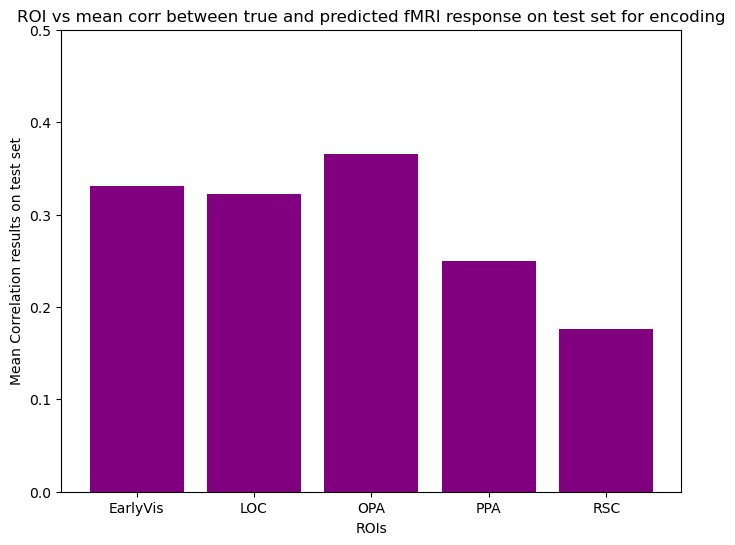

In [32]:
strings=['EarlyVis','LOC','OPA','PPA','RSC']
plt.figure(figsize=(8, 6))
plt.bar(strings, avg_corr_encoding, color='purple')
plt.xlabel('ROIs')
plt.ylabel('Mean Correlation results on test set')
plt.title('ROI vs mean corr between true and predicted fMRI response on test set for encoding')
plt.ylim(0, 0.5)
plt.show()

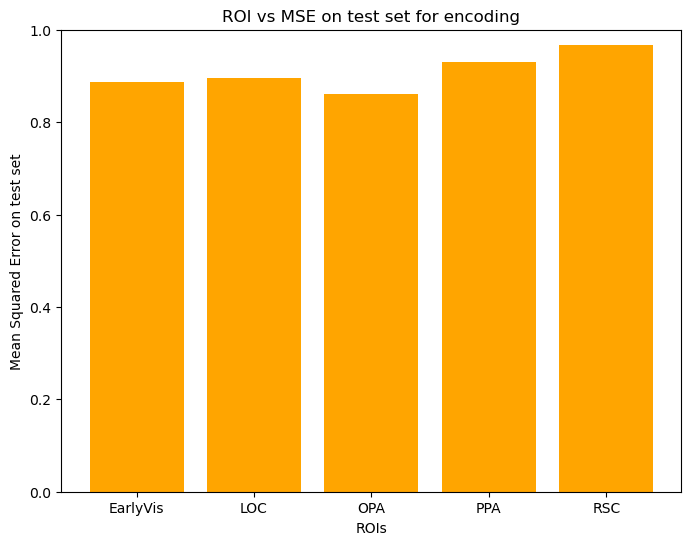

In [33]:
strings=['EarlyVis','LOC','OPA','PPA','RSC']
plt.figure(figsize=(8, 6))
plt.bar(strings, mse_encoding, color='orange')
plt.xlabel('ROIs')
plt.ylabel('Mean Squared Error on test set')
plt.title('ROI vs MSE on test set for encoding')
plt.ylim(0, 1)
plt.show()

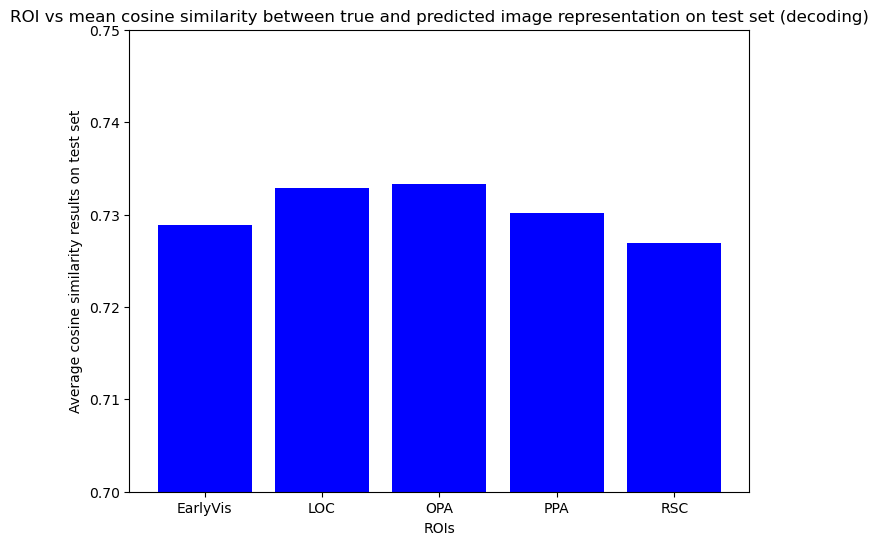

In [34]:
strings=['EarlyVis','LOC','OPA','PPA','RSC']
plt.figure(figsize=(8, 6))
plt.bar(strings, avg_cossim_decoding, color='blue')
plt.xlabel('ROIs')
plt.ylabel('Average cosine similarity results on test set')
plt.title('ROI vs mean cosine similarity between true and predicted image representation on test set (decoding)')
plt.ylim(0.7,0.75)
plt.show()

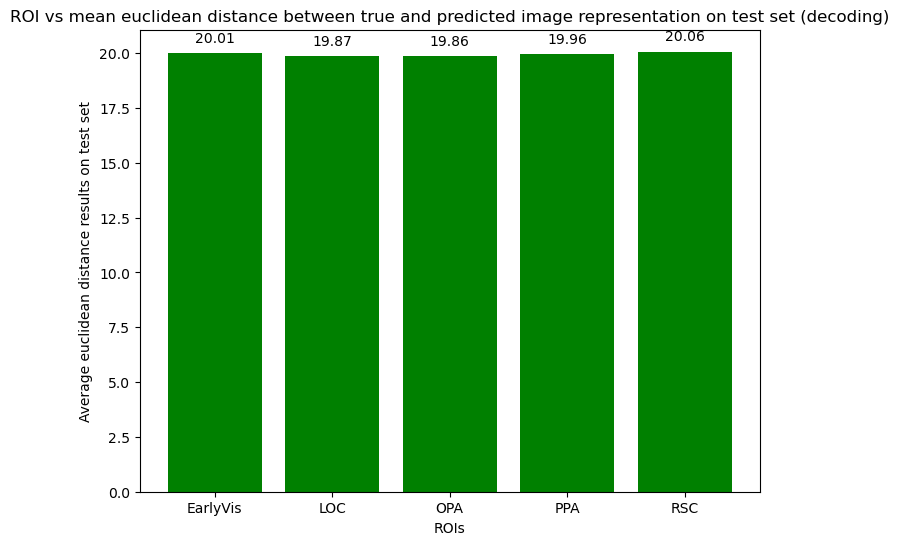

In [35]:
strings=['EarlyVis','LOC','OPA','PPA','RSC']
plt.figure(figsize=(8, 6))
plt.bar(strings, eucdist_decoding, color='green')
for i, value in enumerate(eucdist_decoding):
    plt.text(i, value + 0.5, '{:.2f}'.format(value), ha='center')
plt.xlabel('ROIs')
plt.ylabel('Average euclidean distance results on test set')
plt.title('ROI vs mean euclidean distance between true and predicted image representation on test set (decoding)')
plt.show()